In [1088]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [1089]:
df = pd.read_parquet("Skim_10_11.parquet")

In [1090]:
df["label"] = 0
df = df[df['weight']>0 ]

In [1091]:
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

In [1092]:
df = df[~df.process.str.contains("QCD")]
#df = df[~df.process.str.contains("GluGluHToGG")]
#df = df[~df.process.str.contains("VBFToGG")]
#df = df[~df.process.str.contains("TTWJets")]
#df = df[~df.process.str.contains("TTGG_0Jets_")]
#df = df[~df.process.str.contains("TTGamma")]
#df = df[~df.process.str.contains("WW_Tune")]
#df = df[~df.process.str.contains("THQ_ctc")]
#df = df[~df.process.str.contains("W1Jets")]
#df = df[~df.process.str.contains("W2Jets")]
#df = df[~df.process.str.contains("W3Jets")]



#df.to_csv("dataframe_HHWWgg_withoutDY.csv")

In [1093]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [1094]:
batch_size = 128


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [1095]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.000914 [35.848 events] 
	... background :   114.762628 [92.152 events]


In [1096]:
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

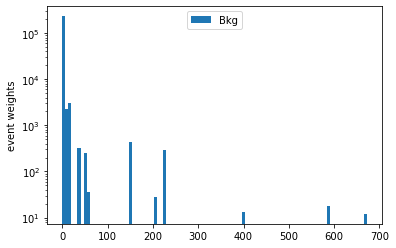

In [1097]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.hist(df.loc[df['label']==0,'weight'],bins=100,label='Bkg')
plt.yscale('log') 
plt.ylabel('event weights')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("event_weights_B.pdf", dpi = 300)



In [1098]:
HHsum_weighted = df[df['label']==1]['weight'].sum()
print(HHsum_weighted)
HHsum_unweighted = 614702.0
bckgsum_weighted = df[df['label']==0]['weight'].sum() 
print(bckgsum_weighted)
classweight_Target = HHsum_unweighted

print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
df.loc[df['label']==1,'weight'] *= df.shape[0]/2 / df[df['label']==1]['weight'].sum() 
df.loc[df['label']==0,'weight'] *= df.shape[0]/2 / df[df['label']==0]['weight'].sum()
# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1

#df.loc[df['label']==1, 'classweight'] = classweight_Target/HHsum_weighted
#df.loc[df['label']==0, 'classweight'] = (classweight_Target/bckgsum_weighted)

#df["trainingweights"] = df.loc[:,'classweight']*df.loc[:,'weight']
print ("After equalization")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

#print (f"Sum of learning weight for signal     = {df[df['label']==1]['trainingweights'].sum():15.5f}")
#print (f"Sum of learning weight for background = {df[df['label']==0]['trainingweights'].sum():15.5f}")

#print (f'Average learning weight = {df["trainingweights"].mean()}')
print (f'Average learning weight = {df["weight"].mean()}')

print ('\nNow let us try again with batches')
checkBatches(df)

2.3459592
289708.8
Sum of learning weight for signal     =         2.34596
Sum of learning weight for background =    289708.81250
After equalization
Sum of learning weight for signal     =    614702.13625
Sum of learning weight for background =    614701.97388
Average learning weight = 3.723165407215305

Now let us try again with batches
On average, per batch the total learning weight is
	... signal     :     0.000908 [35.611 events] 
	... background :   116.286455 [92.389 events]


In [1099]:
batch_size = 128


def checkBatches_X(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['trainingweights'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['trainingweights'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')


checkBatches_X(df)

On average, per batch the total learning weight is
	... signal     :   237.220263 [35.496 events] 
	... background :   244.912028 [92.504 events]


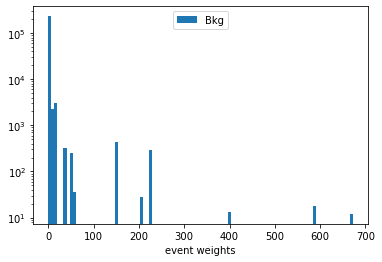

In [1100]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(df.loc[df['label']==0,'weight'],bins=100,label='Bkg')
plt.yscale('log') 
plt.xlabel('event weights')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("event_weights_A.pdf", dpi = 300)

In [1101]:
input_vars=["Eta_ph1",
            "Phi_ph1",
            "E_mGG_ph1",
            "pT_mGG_ph1",
            "Eta_ph2",
            "Phi_ph2",
            "E_mGG_ph2",
            "pT_mGG_ph2",
            "Electron_E",
            "Electron_pT",
            "Electron_Eta",
            "Electron_Phi",
            "Muon_E",
            "Muon_pT",
            "Muon_Eta",
            "Muon_Phi",
            "nJets",
            "E_jet1",
            "pT_jet1",
            "Eta_jet1",
            "Phi_jet1",
            "E_jet2",
            "pT_jet2",
            "Eta_jet2",
            "Phi_jet2",
            "InvM_jet",
            "InvM_jet2",
            "met"]

In [1102]:
print(df[input_vars])

      Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  E_mGG_ph2  \
0    1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   2.097534   
1   -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   2.815203   
2    0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   0.430226   
3    1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   6.344330   
4   -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   0.565238   
..        ...       ...        ...         ...       ...       ...        ...   
687  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   0.569781   
688  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   0.728969   
689  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   1.145351   
690  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   1.119852   
691 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   0.297948   

     pT_mGG_ph2  Electron_E

In [1103]:
#df_clean = df[input_vars].copy()
#df_clean["label"] = df.loc[:,"label"]
#df_clean.to_csv("dataframe_HHWWgg.csv")
print(df)

       weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    0.000025  1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1    0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2    0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
3    0.000025  1.962913 -3.129909   4.803318    1.323140  2.307431 -2.418910   
4    0.000025 -1.630125 -1.711777   1.767290    0.666849 -0.139589 -1.830953   
..        ...       ...       ...        ...         ...       ...       ...   
687  0.784736  0.892076 -0.133293   0.600080    0.421109 -1.847214 -0.196785   
688  0.784736  2.357798  0.196086   8.277598    1.552687  2.074468 -2.216101   
689  0.784736  0.037749  2.375303   0.662115    0.661643  1.665867  2.953054   
690  0.784736  2.519501  1.856302   4.363004    0.697919  1.706206 -0.204428   
691  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   

     E_mGG_ph2  pT_mGG_ph2  Electron_E 

In [1110]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.trainingweights, 
                                                    test_size=0.50, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df[input_vars], df.label, test_size=0.50, random_state=42)

In [1111]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
142513 -0.385575  2.709306   0.347005    0.322718 -2.956677 -0.869275   
1618    0.112896  1.427707   0.757874    0.753069  0.172260 -1.941152   
134413 -0.435258  1.577285   0.619663    0.565267  0.529058 -1.379965   
78981  -2.019576 -0.504911   3.107899    0.810632 -1.803933  1.376590   
63197  -1.135346 -1.246751   4.155190    2.420338 -0.433520 -1.021132   
...          ...       ...        ...         ...       ...       ...   
38271  -0.422716  0.049085   0.901017    0.826103 -0.930341 -2.768962   
248399 -0.850894  1.326952   0.794571    0.573952  0.098221 -0.508540   
56695   0.405075  0.528407   0.776439    0.716821  1.559154  1.540974   
78313   1.093404  2.072151   3.586437    2.160837  1.535816  0.860055   
41469   0.879004 -0.960349   1.441053    1.020686 -0.047667 -1.703802   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
142513   1.996195    0.207010  110.396034    60.

In [1112]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
121027 -0.973898 -2.712737   0.822480    0.543635 -1.601215  1.059530   
227275 -0.192320 -2.211417   1.066592    1.047166 -1.148592 -2.415203   
93748  -1.036928 -1.749705   1.043464    0.657283  0.344046 -2.429103   
16844  -2.125633 -2.266939   3.471472    0.817052 -1.818187  1.513382   
4273   -0.018692  1.210890   0.621947    0.621839 -0.370970 -2.518388   
...          ...       ...        ...         ...       ...       ...   
114717  0.444396 -0.714781   0.707102    0.642599 -0.515669  1.653890   
97494   1.232387 -1.479875   1.214622    0.652847  2.489943  2.140240   
16784   0.396633 -2.403319   0.812599    0.752618 -0.720263 -1.771893   
7189    0.622207  0.090216   2.711518    2.259793 -0.316656  0.224035   
116978 -0.116534 -1.776304   1.186072    1.178064 -0.750116 -0.417573   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
121027   1.180170    0.457368   56.867294    56.

In [1113]:
parameters = {
    'epochs'                : 100,
    'lr'                    : 0.001,
    'batch_size'            : 128,
    'n_layers'              : 4,
    'n_neurons'             : 128,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
}

In [1114]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_1")(inputs)
for i in range(1,parameters['n_layers']):
    x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_{i+1}")(x)
outputs = layers.Dense(1, activation=parameters['output_activation'], name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [1115]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    #optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()


Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 28)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3712      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 53,377
Trainable params: 53,377
Non-trainabl

In [1116]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
142513 -0.385575  2.709306   0.347005    0.322718 -2.956677 -0.869275   
1618    0.112896  1.427707   0.757874    0.753069  0.172260 -1.941152   
134413 -0.435258  1.577285   0.619663    0.565267  0.529058 -1.379965   
78981  -2.019576 -0.504911   3.107899    0.810632 -1.803933  1.376590   
63197  -1.135346 -1.246751   4.155190    2.420338 -0.433520 -1.021132   
...          ...       ...        ...         ...       ...       ...   
38271  -0.422716  0.049085   0.901017    0.826103 -0.930341 -2.768962   
248399 -0.850894  1.326952   0.794571    0.573952  0.098221 -0.508540   
56695   0.405075  0.528407   0.776439    0.716821  1.559154  1.540974   
78313   1.093404  2.072151   3.586437    2.160837  1.535816  0.860055   
41469   0.879004 -0.960349   1.441053    1.020686 -0.047667 -1.703802   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
142513   1.996195    0.207010  110.396034    60.

In [1117]:
# Callbacks #
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01, 
                               patience = 100,
                               verbose=1,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0, 
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from history import LossHistory, PlotHistory
loss_history = LossHistory()

history = model.fit(
    X_train,
    y_train,
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test,w_test),
    #validation_data=(X_test, y_test),
    callbacks = [early_stopping, reduce_plateau, loss_history],
)


Epoch 1/100
1290/1290 - 25s - loss: 3.5680 - binary_accuracy: 0.4551 - auc_36: 0.5550 - precision_36: 0.3051 - recall_36: 0.7449 - val_loss: 2.1750 - val_binary_accuracy: 0.3862 - val_auc_36: 0.5108 - val_precision_36: 0.2767 - val_recall_36: 0.7490 - lr: 0.0010 - 25s/epoch - 19ms/step
Epoch 2/100
1290/1290 - 4s - loss: 2.1719 - binary_accuracy: 0.4522 - auc_36: 0.5622 - precision_36: 0.3062 - recall_36: 0.7597 - val_loss: 2.2116 - val_binary_accuracy: 0.6322 - val_auc_36: 0.6345 - val_precision_36: 0.3805 - val_recall_36: 0.5155 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 3/100
1290/1290 - 4s - loss: 2.1394 - binary_accuracy: 0.4642 - auc_36: 0.5678 - precision_36: 0.3071 - recall_36: 0.7316 - val_loss: 2.0571 - val_binary_accuracy: 0.4624 - val_auc_36: 0.5045 - val_precision_36: 0.2903 - val_recall_36: 0.6472 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 4/100
1290/1290 - 3s - loss: 2.1176 - binary_accuracy: 0.4659 - auc_36: 0.5567 - precision_36: 0.3073 - recall_36: 0.7282 - val_loss: 2.212

Epoch 30/100
1290/1290 - 4s - loss: 1.7833 - binary_accuracy: 0.4856 - auc_36: 0.5781 - precision_36: 0.3220 - recall_36: 0.7617 - val_loss: 1.9446 - val_binary_accuracy: 0.3964 - val_auc_36: 0.5385 - val_precision_36: 0.3008 - val_recall_36: 0.8850 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 31/100
1290/1290 - 4s - loss: 1.8552 - binary_accuracy: 0.4832 - auc_36: 0.5781 - precision_36: 0.3207 - recall_36: 0.7612 - val_loss: 1.7312 - val_binary_accuracy: 0.5282 - val_auc_36: 0.6174 - val_precision_36: 0.3451 - val_recall_36: 0.7773 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 32/100
1290/1290 - 4s - loss: 1.8265 - binary_accuracy: 0.4882 - auc_36: 0.5832 - precision_36: 0.3238 - recall_36: 0.7657 - val_loss: 1.7017 - val_binary_accuracy: 0.4449 - val_auc_36: 0.5561 - val_precision_36: 0.3071 - val_recall_36: 0.7943 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 33/100
1290/1290 - 4s - loss: 1.8395 - binary_accuracy: 0.4878 - auc_36: 0.5825 - precision_36: 0.3232 - recall_36: 0.7627 - val_loss: 2.01

Epoch 59/100
1290/1290 - 4s - loss: 1.4576 - binary_accuracy: 0.4888 - auc_36: 0.6476 - precision_36: 0.3321 - recall_36: 0.8220 - val_loss: 1.4686 - val_binary_accuracy: 0.5185 - val_auc_36: 0.6551 - val_precision_36: 0.3435 - val_recall_36: 0.8046 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 60/100
1290/1290 - 4s - loss: 1.4345 - binary_accuracy: 0.4846 - auc_36: 0.6376 - precision_36: 0.3308 - recall_36: 0.8270 - val_loss: 1.4642 - val_binary_accuracy: 0.4694 - val_auc_36: 0.6344 - val_precision_36: 0.3235 - val_recall_36: 0.8334 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 61/100
1290/1290 - 4s - loss: 1.4349 - binary_accuracy: 0.4835 - auc_36: 0.6362 - precision_36: 0.3301 - recall_36: 0.8253 - val_loss: 1.7054 - val_binary_accuracy: 0.4272 - val_auc_36: 0.6444 - val_precision_36: 0.3154 - val_recall_36: 0.9069 - lr: 1.0000e-04 - 4s/epoch - 3ms/step
Epoch 62/100
1290/1290 - 4s - loss: 1.4738 - binary_accuracy: 0.4843 - auc_36: 0.6374 - precision_36: 0.3300 - recall_36: 0.8220 - va

Epoch 87/100
1290/1290 - 4s - loss: 1.4832 - binary_accuracy: 0.4777 - auc_36: 0.6131 - precision_36: 0.3289 - recall_36: 0.8364 - val_loss: 1.5592 - val_binary_accuracy: 0.4697 - val_auc_36: 0.6063 - val_precision_36: 0.3245 - val_recall_36: 0.8398 - lr: 1.0000e-06 - 4s/epoch - 3ms/step
Epoch 88/100
1290/1290 - 4s - loss: 1.4871 - binary_accuracy: 0.4742 - auc_36: 0.6115 - precision_36: 0.3276 - recall_36: 0.8391 - val_loss: 1.5638 - val_binary_accuracy: 0.4684 - val_auc_36: 0.6063 - val_precision_36: 0.3242 - val_recall_36: 0.8422 - lr: 1.0000e-06 - 4s/epoch - 3ms/step
Epoch 89/100
1290/1290 - 4s - loss: 1.4859 - binary_accuracy: 0.4761 - auc_36: 0.6128 - precision_36: 0.3284 - recall_36: 0.8386 - val_loss: 1.5513 - val_binary_accuracy: 0.4767 - val_auc_36: 0.6092 - val_precision_36: 0.3268 - val_recall_36: 0.8336 - lr: 1.0000e-06 - 4s/epoch - 3ms/step
Epoch 90/100
1290/1290 - 4s - loss: 1.4826 - binary_accuracy: 0.4797 - auc_36: 0.6142 - precision_36: 0.3297 - recall_36: 0.8356 - va

Curves saved as Loss_TTOXTIOLTM.png


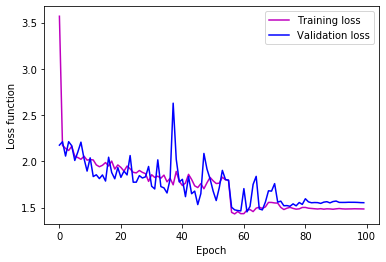

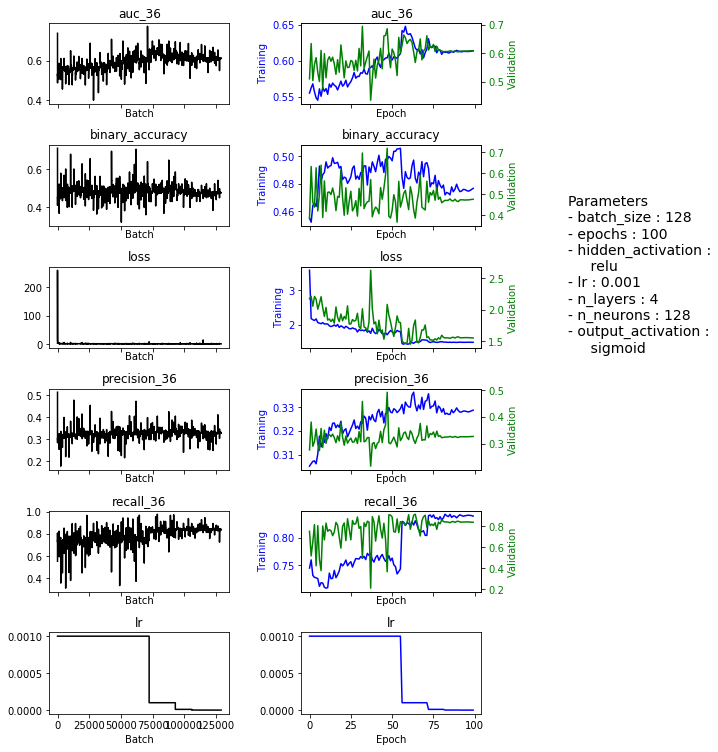

In [1118]:
from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
fig.savefig('training_validation.pdf')

PlotHistory(loss_history,params=parameters)
# Params is a dict of parameters with name and values
# used for plotting


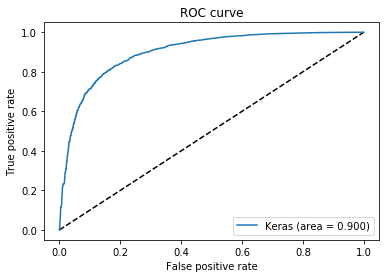

[0.         0.00141966 0.00146321 ... 0.99997823 0.99997823 1.        ]
[0.00000000e+00 5.55158429e-05 5.57677420e-05 ... 9.99951477e-01
 9.99999995e-01 1.00000000e+00]
[2.0000000e+00 1.0000000e+00 9.9999988e-01 ... 1.0994114e-25 4.2949893e-26
 0.0000000e+00]
Threshold value is: 0.5100454


In [1126]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig("ROC_curve.pdf")
plt.show()
print(tpr_keras)
print(fpr_keras)
print(thresholds_keras)
optimal_idx = np.argmax(tpr_keras - fpr_keras)
optimal_threshold = thresholds_keras[optimal_idx]
print("Threshold value is:", optimal_threshold)


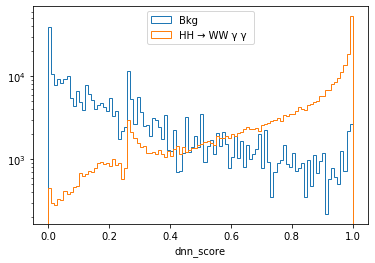

In [1120]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(prediction[y_test==0],weights=w_test[y_test==0],histtype=("step"),bins=100,label='Bkg')
plt.hist(prediction[y_test==1],weights=w_test[y_test==1],histtype=("step"),bins=100,label='HH \u2192 WW \u03B3 \u03B3 ')
plt.yscale('log') 
plt.xlabel('dnn_score')
#plt.ylabel('')
#plt.title('dnn_score')
plt.legend(loc='upper center')
fig.savefig("prediction.pdf", dpi = 300)

In [1121]:
# evaluate the model
scores = model.evaluate(X_test, y_test, sample_weight=w_test, verbose=2)
#scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

5160/5160 - 4s - loss: 1.5532 - binary_accuracy: 0.4763 - auc_36: 0.6094 - precision_36: 0.3268 - recall_36: 0.8349 - 4s/epoch - 734us/step
binary_accuracy: 47.63%


In [1058]:
# save model and architecture to single file
model.save("model_dnn_10_11")
print("Saved model to disk")

INFO:tensorflow:Assets written to: model_dnn_10_11/assets
Saved model to disk
